In [3]:
import pandas as pd
import os 
import glob

In [18]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/reference/gene_table.parquet"
gdf = pd.read_parquet(fpath)
gdf.head()

,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
0,ENSMUSG00000104478,Gm38212,havana,TEC,1,108344806,108347562,2756,108346184,False
1,ENSMUSG00000104385,Gm7449,havana,processed_pseudogene,1,6980783,6981446,663,6981114,False
2,ENSMUSG00000102135,Gm37108,havana,processed_pseudogene,1,6986782,6993812,7030,6990297,False
3,ENSMUSG00000103282,Gm37275,havana,processed_pseudogene,1,6999982,7000012,30,6999997,False
4,ENSMUSG00000101097,Gm6679,havana,processed_pseudogene,1,108697864,108699733,1869,108698798,False


In [5]:
dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/"
file_list = glob.glob(f"{dpath}*.tsv")
file_list = [x for x in file_list if not "processed" in x]
file_list

['/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFI8CSCJWM.tsv',
 '/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFICXJQ3PA.tsv',
 '/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFI3YYNDKI.tsv',
 '/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFIPYGE7JR.tsv',
 '/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFIYTCHMIZ.tsv',
 '/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/RNAseq/4DNFIC269AEU.tsv']

In [36]:
usecols = [
    'gene_id',
    'TPM', 
]

df = []
for fpath in file_list:
    file_id = os.path.basename(fpath).replace(".tsv", "")
    # file_id = fpath.
    edf = pd.read_csv(fpath, sep='\t', usecols=usecols)
    edf['gene_id'] = edf['gene_id'].apply(lambda x: x.split(".")[0])
    
    # filter genes not in GTF
    edf = edf[edf['gene_id'].isin(gdf['gene_id'].unique())]

    # sum expression over all isoforms
    edf = edf.groupby('gene_id').agg(
        TPM = ('TPM', 'sum'),
    ).reset_index()
    
    edf = edf.set_index('gene_id')
    edf.columns = [f"{file_id}_TPM"]
    df.append(edf)
    
    
df = pd.concat(df, axis=1)
df.head()

,4DNFI8CSCJWM_TPM,4DNFICXJQ3PA_TPM,4DNFI3YYNDKI_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,4DNFIC269AEU_TPM
gene_id,,,,,,
ENSMUSG00000000001,2.53,46.79,2.65,2.65,2.53,46.79
ENSMUSG00000000003,0.00,0.00,0.00,0.00,0.00,0.00
ENSMUSG00000000028,5.58,57.58,4.87,4.87,5.58,57.58
ENSMUSG00000000031,0.15,4.98,0.25,0.25,0.15,4.98
ENSMUSG00000000037,6.42,1.21,8.13,8.11,6.42,1.22


In [37]:
df = pd.merge(df, gdf,
              how='left',
              left_index=True,
              right_on='gene_id')

df.head()

,4DNFI8CSCJWM_TPM,4DNFICXJQ3PA_TPM,4DNFI3YYNDKI_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,4DNFIC269AEU_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
9792,2.53,46.79,2.65,2.65,2.53,46.79,ENSMUSG00000000001,Gnai3,ensembl_havana,protein_coding,3,108014595,108053462,38867,108034028,False
55045,0.00,0.00,0.00,0.00,0.00,0.00,ENSMUSG00000000003,Pbsn,ensembl_havana,protein_coding,X,76881506,76897229,15723,76889367,False
47046,5.58,57.58,4.87,4.87,5.58,57.58,ENSMUSG00000000028,Cdc45,ensembl_havana,protein_coding,16,18599196,18630737,31541,18614966,False
24546,0.15,4.98,0.25,0.25,0.15,4.98,ENSMUSG00000000031,H19,ensembl_havana,lncRNA,7,142129261,142131917,2656,142130589,False
53513,6.42,1.21,8.13,8.11,6.42,1.22,ENSMUSG00000000037,Scml2,ensembl_havana,protein_coding,X,159865520,160041209,175689,159953364,False


<Axes: >

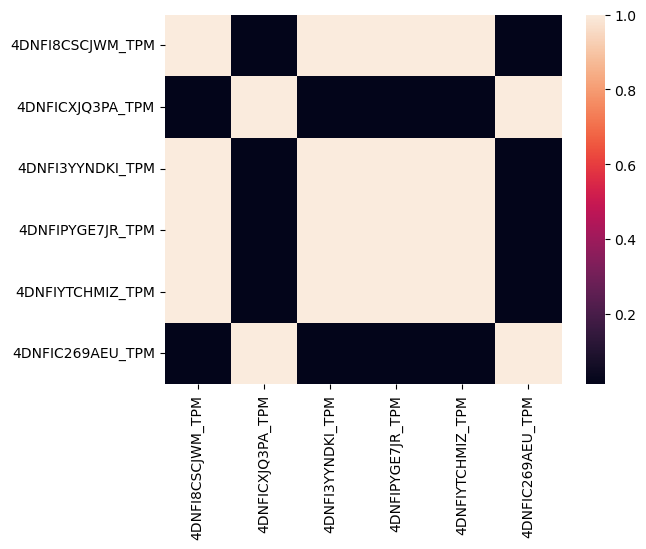

In [33]:
import seaborn as sns
sns.heatmap(df.corr())

In [48]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/rna/expression.parquet"
df = pd.read_parquet(fpath)
df = df[df['gene_biotype'] == 'protein_coding']
print(df.shape)
df.head()

(21542, 14)


,4DNFI3YYNDKI_TPM,4DNFI8CSCJWM_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
0,2.65,2.53,2.65,2.53,ENSMUSG00000000001,Gnai3,ensembl_havana,protein_coding,3,108014595,108053462,38867,108034028,False
1,0.00,0.00,0.00,0.00,ENSMUSG00000000003,Pbsn,ensembl_havana,protein_coding,X,76881506,76897229,15723,76889367,False
2,4.87,5.58,4.87,5.58,ENSMUSG00000000028,Cdc45,ensembl_havana,protein_coding,16,18599196,18630737,31541,18614966,False
4,8.13,6.42,8.11,6.42,ENSMUSG00000000037,Scml2,ensembl_havana,protein_coding,X,159865520,160041209,175689,159953364,False
5,0.00,0.00,0.00,0.00,ENSMUSG00000000049,Apoh,ensembl_havana,protein_coding,11,108234179,108305222,71043,108269700,False


In [49]:
df = df.sort_values(by='4DNFI3YYNDKI_TPM', ascending=False)
df.head()

,4DNFI3YYNDKI_TPM,4DNFI8CSCJWM_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
10820,974.43,1069.62,974.42,1069.62,ENSMUSG00000037742,Eef1a1,ensembl_havana,protein_coding,9,78385730,78396433,10703,78391081,False
17000,537.54,578.67,537.54,578.67,ENSMUSG00000060461,Dppa5a,ensembl_havana,protein_coding,9,78274333,78275459,1126,78274896,False
1136,503.36,539.01,503.36,539.01,ENSMUSG00000007892,Rplp1,ensembl_havana,protein_coding,9,61820565,61821824,1259,61821194,False
20419,382.17,414.03,382.17,414.05,ENSMUSG00000074129,Rpl13a,ensembl_havana,protein_coding,7,44774981,44778185,3204,44776583,False
29777,369.52,484.51,369.51,484.51,ENSMUSG00000090733,Rps27,ensembl_havana,protein_coding,3,90119828,90120958,1130,90120393,False


In [50]:
df[df['is_tf']].head()

# df.sort_values()

,4DNFI3YYNDKI_TPM,4DNFI8CSCJWM_TPM,4DNFIPYGE7JR_TPM,4DNFIYTCHMIZ_TPM,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf
862,176.44,205.38,176.43,205.39,ENSMUSG00000005566,Trim28,ensembl_havana,protein_coding,7,12733040,12764962,31922,12749001,True
4471,58.87,68.70,58.86,68.69,ENSMUSG00000024406,Pou5f1,ensembl_havana,protein_coding,17,35816914,35821669,4755,35819291,True
10212,54.61,54.71,54.61,54.70,ENSMUSG00000036036,Zfp57,ensembl_havana,protein_coding,17,37312054,37321527,9473,37316790,True
6799,49.66,44.97,49.66,44.97,ENSMUSG00000028639,Ybx1,ensembl_havana,protein_coding,4,119135177,119151801,16624,119143489,True
17670,44.46,38.65,44.47,38.65,ENSMUSG00000063524,Eno1,ensembl_havana,protein_coding,4,150321177,150333336,12159,150327256,True


In [19]:
edf.tail

<bound method NDFrame.tail of                    gene_id  TPM  length
0                    10000  0.0      72
1                    10001  0.0      73
2                    10002  0.0      73
3                    10003  0.0      75
4                    10004  0.0      78
...                    ...  ...     ...
81876  gSpikein_ERCC-00165  0.0     872
81877  gSpikein_ERCC-00168  0.0    1024
81878  gSpikein_ERCC-00170  0.0    1023
81879  gSpikein_ERCC-00171  0.0     505
81880     gSpikein_phiX174  0.0    5386

[81881 rows x 3 columns]>